# AI Summerschool: Probabalistic Sensor Models

In this demo we'll look at making sensor models, which allow you to calculate quantities of interest in fusion from raw sensor readings. In fusion, often the quantity measured by a sensor is not the same as the quantity we want to infer from that measurement.

For example, Thomson scattering measures spectra of scattered laser light. But the quantities we infer from thomson scattering include plasma density and temperature. 

In this demo we'll look specifically at equilibrium reconstruction using an array of magnetic sensors. Rather than use a physics-based aproach, we use a data-driven aproach, creating a model that can relate magnetic properties of a plasma to sensor readings by training on historical data from MAST. 

This demo will be split into three parts:

1. Getting setup
2. Loading in our data
3. Training a simple model
4. Adding more sensors
5. Functional Predicitons





## Getting setup

First we'll import our generic packages and define some useful functions


In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import random



def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def polar_to_cartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

Then we'll import twinLab, one of digiLab's tools for developing probabalistic machine learning models

In [ ]:
import twinlab as tl
tl.set_api_key("")

## Loading Data

Next let's load in our data, which has been produced using the FAIR MAST database. The data consists of two basic quantities:

- Readings from magnetic sensors
- Characteristics of the magnetic shape of the plasma

Let's visualise this data, by plotting the sensor readings of one magnetic sensor against the elongation. Try choosing different sensors to see how the data looks.


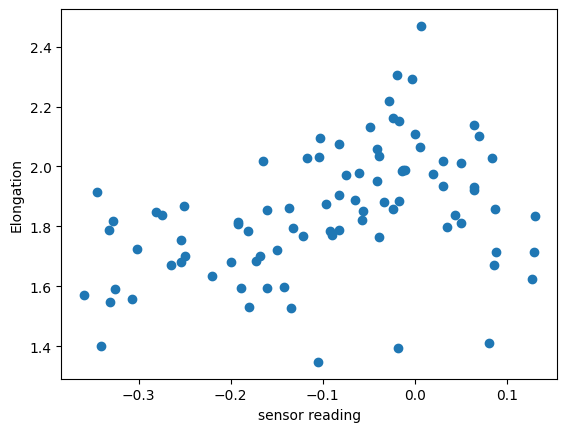

In [117]:
df = pd.read_csv("magnetics_data.csv")

X = df["amb_ccbv01  \n"] #sensor readings
Y = df["Elongation"]
plt.scatter(X,Y)
plt.xlabel("sensor reading")
plt.ylabel("Elongation")
plt.show()

Now lets upload our data to the digiLab cloud so that we can build emulators with it later.

In [118]:

# Intialise a Dataset object
dataset_id = "Magnetics_dataset"
dataset = tl.Dataset(id=dataset_id)

# Define test and train size
train_len = 60
eval_len = len(df) - train_len

# Define train and test data
df_train = df[:train_len]
df_eval = df[train_len : train_len + eval_len]

# Upload the dataset
dataset.upload(df_train, verbose=True)

Dataframe is uploading.
Dataset successfully uploaded.


## Building our Model

Next let's build our probabalistic sensor model, by training a Gaussian Process on historical data. First let's define our relevant inputs and outputs. 

For our outputs, we want the very important shape parameters of our plasma, including the elongation and triangularity.

For our input, we randomly select the readings of one of the 125 sensors in the MAST poloidal magnetic sensor array.

In [119]:

random.seed(42)
number_sensors = 1
sensorindices_kept = random.sample(range(1, 125), number_sensors)# chosen sensors
input_columns = list(df.keys()[sensorindices_kept]) #columns representing sensor readings

output_columns_simple = ["Elongation","Triangularity"]


Then, we'll build a simple 1d gaussian process with torch. This is quite an involved process, where we need to define a kernel, calculate the covariance and invert the resultant matrix. 

We also see the produced results leave something to be desired. It could be improved by changing our length_scale, variance, and noise parameters.

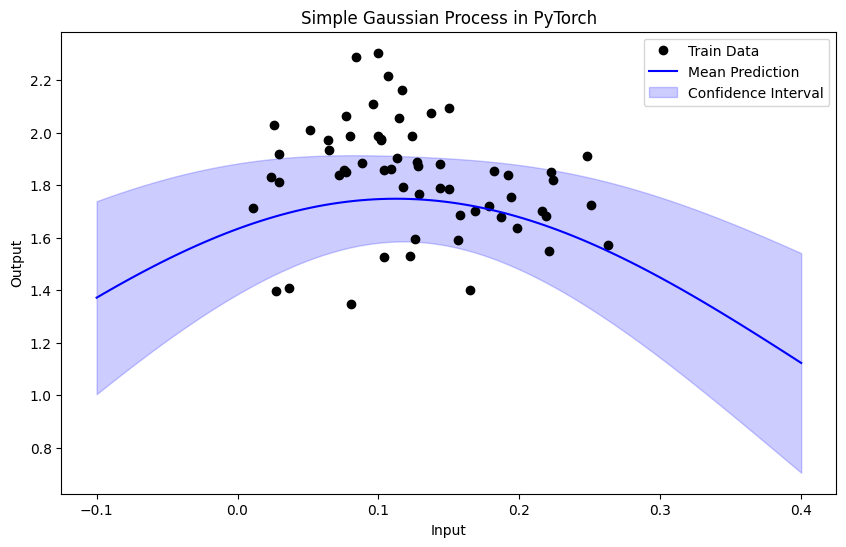

In [120]:

import torch

# Define the RBF Kernel 
def rbf_kernel(x1, x2, length_scale=0.3, variance=0.1):
    x1 = x1.unsqueeze(1)  # (n, 1)
    x2 = x2.unsqueeze(0)  # (1, m)
    dist_sq = (x1 - x2)**2
    return variance * torch.exp(-0.5 * dist_sq / length_scale**2)

#Training data 
X_train = torch.tensor(np.array(df_train[input_columns]), dtype=torch.float32).squeeze()
y_train = torch.tensor(np.array(df_train["Elongation"]), dtype=torch.float32).squeeze()

# Test points
X_test = torch.linspace(-0.1, 0.4, 100)

# Compute Kernels 
noise = 0.4
K = rbf_kernel(X_train, X_train) 
K += noise * torch.eye(len(X_train))  # Add observation noise
K_s = rbf_kernel(X_train, X_test)
K_ss = rbf_kernel(X_test, X_test)

# Matrix Inversion and prediction
K_inv = torch.inverse(K)
mu_s = K_s.T @ K_inv @ y_train
cov_s = K_ss - K_s.T @ K_inv @ K_s
std_s = torch.sqrt(torch.diag(cov_s))

#  Plot 
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'ko', label='Train Data')
plt.plot(X_test, mu_s, 'b', label='Mean Prediction')
plt.fill_between(X_test, mu_s - 2*std_s, mu_s + 2*std_s, color='blue', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title("Simple Gaussian Process in PyTorch")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

Now we'll do the same thing again in twinLab, one of digiLab's platforms for probabalistic machine learning. We simply need to define a gaussian process emulator, and the various functions within twinLab find the perfect GP for us without much effort!

In [122]:

# Initialise emulator
emulator_id = "WM_School_Emulator_Simple"  # Specifies type of emulator
emulator_simple = tl.Emulator(id=emulator_id)

# Define the training parameters for your emulator
params = tl.TrainParams(
    train_test_ratio=1,  # Specifies ratio of train data to test data (0.80 = 80% train data and 20% test data)
    estimator="gaussian_process_regression",  # Specifies type of estimation
)

# train the probabalistic emulator
emulator_simple.train(
    dataset=dataset,
    inputs=input_columns,
    outputs=output_columns_simple,
    params=params,
    verbose=True,
)

Emulator 'WM_School_Emulator_Simple' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:07: Job status: processing
0:00:10: Job status: processing
0:00:12: Job status: success
Training of emulator WM_School_Emulator_Simple is complete!


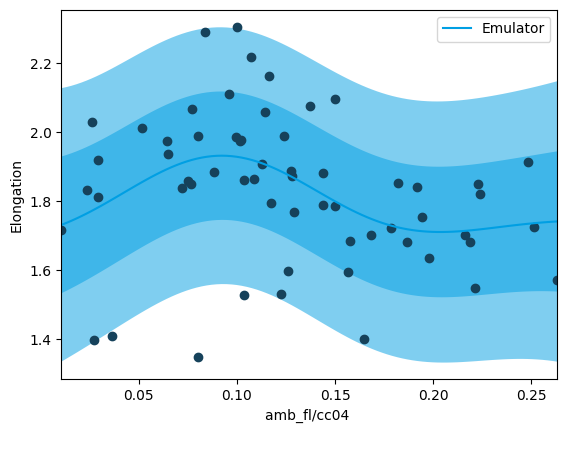

In [123]:
emulator_simple.plot(x_axis=input_columns[0],y_axis="Elongation")
plt.scatter(df_train[input_columns[0]],df_train["Elongation"],color="#16425B",label="training data")
plt.show()


#### Question: why is the data so widely distributed? Can you think of good reasons there is such high uncertainty? 

## Adding More Sensors

Now let's add some more sensors to constrain our probabalistic model further. Try increasing the number of sensors to see what happens to performance of our data driven model against the ground truth.

In [98]:
random.seed(42)
number_sensors = 40 # try change the number of sensors we use for our model
sensorindices_kept = random.sample(range(1, 125), number_sensors)# chosen sensors
input_columns = list(df.keys()[sensorindices_kept]) #columns representing sensor readings

params = tl.TrainParams(
    train_test_ratio=1,  # Specifies ratio of train data to test data (0.80 = 80% train data and 20% test data)
    estimator="gaussian_process_regression",  # Specifies type of estimation
    input_retained_dimensions=8,
)
emulator_simple.train(
    dataset=dataset,
    inputs=input_columns,
    outputs=output_columns_simple,
    params=params,
    verbose=True,
)

Emulator 'WM_School_Emulator_Simple' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: success
Training of emulator WM_School_Emulator_Simple is complete!


In [99]:
pred_simple,err_simple = emulator_simple.predict(df_eval,verbose=False)
true = df_eval["Elongation"]

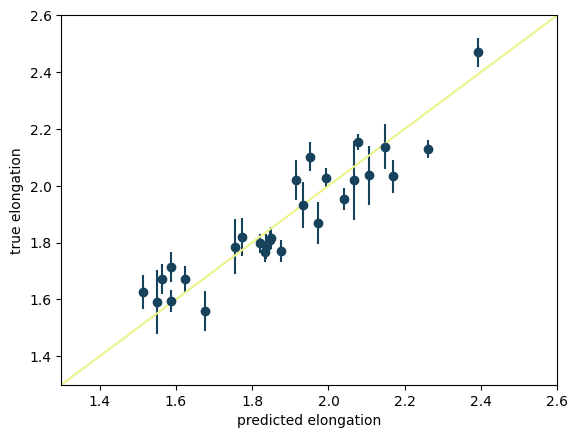

In [100]:
plt.errorbar(pred_simple["Elongation"],true,yerr=np.array(err_simple["Elongation"]).flatten(),linestyle="",marker="o",color="#16425B")
limits = [1.3,2.6]
plt.plot(limits,limits,color="#EBF38B")
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel("predicted elongation")
plt.ylabel("true elongation")
plt.show()

#### If you've got this far, try going back and changing the number of sensors, or even repeat this exercise focusing on triangularity rather than elongation

## Functional Predictions

As well as making a model to predict one important value, we often use sensors to predict entire fields or shapes. So, rather than estimating elongation and triangularity, let's build an model to estimate the entire separatrix, which defines the edge of the core plasma.

This is defined by the last 100 columns in our data file, which give the radius of the plasma in circular coordinates (from -pi to pi radians) measured from R=0.6,Z=0. We use these coordinates because we get a nice well-behaved 1d function to represent the shape. You can see the shapes represented in this circular (left) and tokamak (right) coordinates.

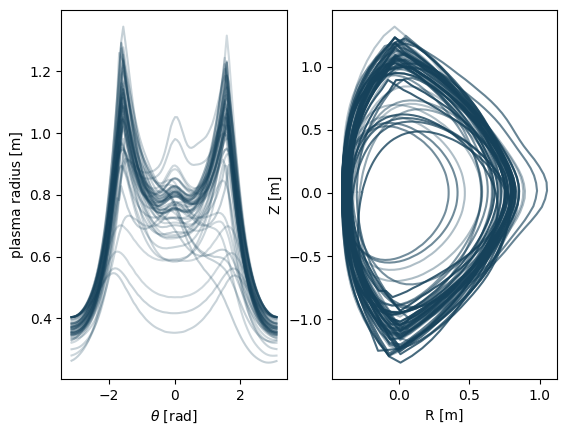

In [101]:
central_axisR = 0.6
Thetaseps = np.linspace(-np.pi,0.99*np.pi,100)#used to make separatraces with 100 points each

output_columns_sep = list(df.keys()[125:225])

fig, axs = plt.subplots(1,2)
plasma_radius =np.array(df_train[output_columns_sep])

basecolor = (0.22,0.66,0.91)
for i in range(len(plasma_radius)):
    R,Z = polar_to_cartesian(r=plasma_radius[i],theta=Thetaseps)
    axs[0].plot(Thetaseps,plasma_radius[i],color="#16425B",alpha=0.2+0.001*i)
    axs[1].plot(R,Z,color="#16425B",alpha=0.3+0.01*i)
axs[0].set_xlabel(r"$\theta$ [rad]")
axs[0].set_ylabel("plasma radius [m]")
axs[1].set_xlabel("R [m]")
axs[1].set_ylabel("Z [m]")
plt.show()

Let's create a new emulator to predict the 100 output columns representing points on the separatrix. 

Now with a Gaussian Process usually that would be incredibly expensive; almost impossible. However, at digiLab we use dimensionality reduction techniques. Such that we sum up the shape of the functions above with only 10 numbers, rather than 100.

In twinLab, this is done with the output_retained_dimensions parameter

In [ ]:
# # Initialise emulator
emulator_id = "WM_Emulator_Sep"  # Specifies type of emulator
emulator_sep = tl.Emulator(id=emulator_id)
params = tl.TrainParams(
    train_test_ratio=1,  # Specifies ratio of train data to test data (0.80 = 80% train data and 20% test data)
    estimator="gaussian_process_regression",  # Specifies type of estimation
    input_retained_dimensions=8,
    output_retained_dimensions=10
)

emulator_sep.train(
    dataset=dataset,
    inputs=input_columns,
    outputs=output_columns_sep,
    params=params,
    verbose=True,
)


Emulator 'WM_Emulator_Sep' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:07: Job status: processing
0:00:10: Job status: processing
0:00:12: Job status: processing
0:00:15: Job status: processing
0:00:19: Job status: success
Training of emulator WM_Emulator_Sep is complete!


Now that our model has finished training, let's see how it performs on test data.

In [ ]:
df_mean, df_std = emulator_sep.predict(df_eval,verbose=False)


And let's run our previous emulator for elongation and triangularity, so we can see all our results together

In [106]:

df_mean_shape, df_std_shape = emulator_simple.predict(df_eval,verbose=False)

And now we can visualise

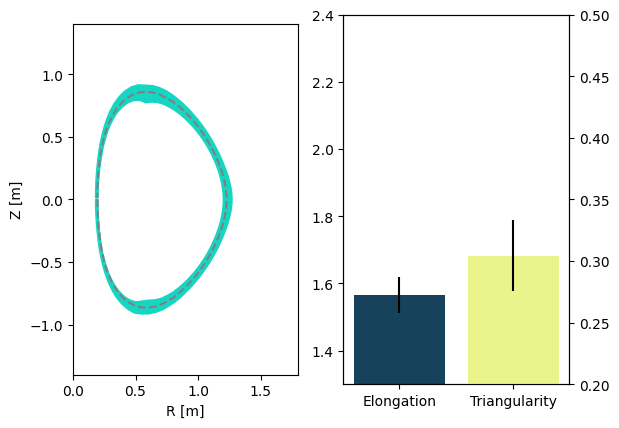

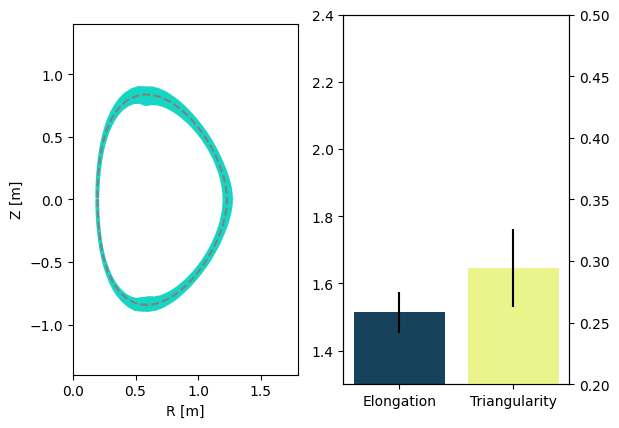

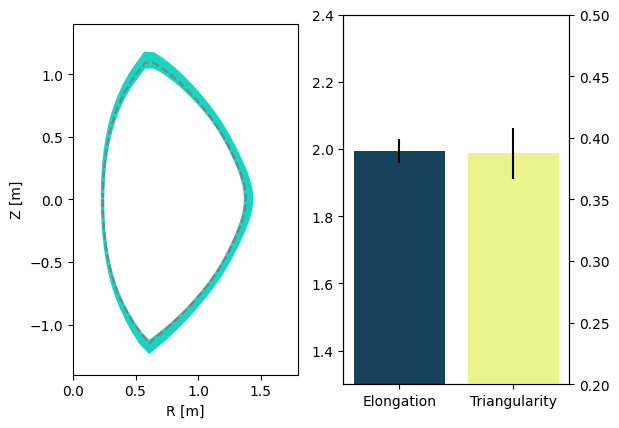

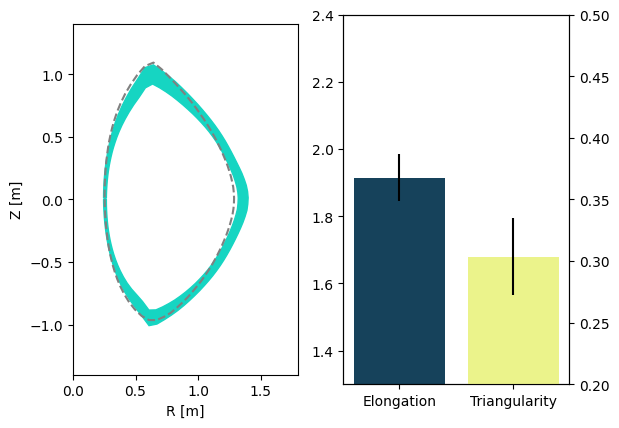

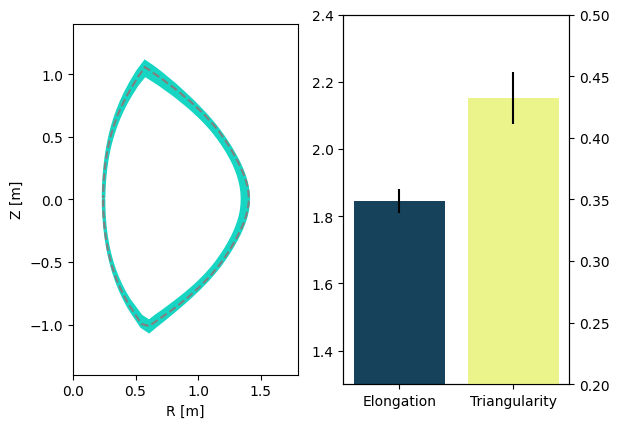

In [108]:
for i in range(5):
    fig, axs = plt.subplots(1,2)
    mean = df_mean[output_columns_sep].iloc[i]
    std = df_std[output_columns_sep].iloc[i]
    true = df_eval[output_columns_sep].iloc[i]
    xmin,ymin = polar_to_cartesian(r=mean-std,theta=Thetaseps)
    # plt.plot(xmin,ymin)
    xmax,ymax = polar_to_cartesian(r=mean+std,theta=Thetaseps)
    xtrue,ytrue = polar_to_cartesian(r=true,theta=Thetaseps)
    # plt.plot(xmax,ymax)
    x = np.concatenate([xmin[::-1], xmax])+central_axisR
    y = np.concatenate([ymin[::-1], ymax])
    xtrue=np.array(xtrue)+central_axisR
    axs[0].set_xlabel("R [m]")
    axs[0].set_ylabel("Z [m]")
    axs[0].fill(x, y, color='#16D5C2')
    axs[0].plot(xtrue,ytrue,color="#808080",linestyle="--")
    axs2 = axs[1].twinx()
    axs[1].bar(x=["Elongation"],height=df_mean_shape["Elongation"].iloc[i],yerr=df_std_shape["Elongation"].iloc[i],color="#16425B")
    axs2.bar(x=["Triangularity"],height=df_mean_shape["Triangularity"].iloc[i],yerr=df_std_shape["Triangularity"].iloc[i],color="#EBF38B")
    axs[1].set_ylim([1.3,2.4])  
    axs2.set_ylim([0.2,0.5])
    axs[0].set_xlim([0,1.8]) 
    axs[0].set_ylim([-1.4,1.4])   
    axs[0].set_aspect("equal")
    plt.show()

### Challenge

We have now built a probabalistic model that can reconstruct the magnetic shape of MAST using measurements.

Now that we have built this model, let's think about more applications for it. In particular, this model allows us to ask questions about sensors. By yourself or in teams, use the model you've built to ask an interesting question about our magnetic sensing system, including:

- How many sensors do we need to add before we get diminishing returns in the observation performance?
- If I could only place 10 sensors, which sensors would I chose?
- What is the most important indevidual sensor out of the 125 provided?

There are many ways you could answer these questions and define a good sensing system. You could look at your model uncertainty, you could use emulator.score on test data, or some other method entirely!